In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

#### Показатели
* прирост ВВП
* инфляция
* процентная ставка

динамика основных переменных

#### Характеристика переменных
* средние значения переменных
* волатильность
* персистетность
(определяются параметрами модели - 15 параметров)

#### Тренировочный набор
1 000 000 пар
* параметры (вектор размера 15)
* данные по приросту ВВП, инфляции и процентной ставки, которые получены из симуляции модели с соответствующими параметрами для 200 последовательных периодов
* 200 последовательных периодов (матрица размером 200 на 3)

### Задача
разработка алгоритма, который по данным сможет предсказывать параметры, с использованием которых эти данные были сгенеированы
какие параметры являются наиболее вероятными, а какие менее вероятными

### Результат
100 000 тестовых примеров (состоящих из 3 рядов длиной 200 периодов)
для каждого из 15-ти параметров должны быть получены 6 характеристик
апостериорного распределения
* среднее 
* 10-я квантиль
* 25-я квантиль
* 50-я квантиль
* 75-я квантиль
* 90-я квантиль

### Данные для тренировки модели

In [2]:
# 3-мерный тренировочный массив 1 000 000 х 15 х 1 с соответствующими параметрами
pars_smp_train = np.load("data/train/pars_smp_train.npy")
pars_smp_train[:3]


array([[[ 0.75344854],
        [ 1.25486516],
        [ 0.48308029],
        [ 0.51552987],
        [ 1.69271804],
        [ 0.07154417],
        [ 1.06875518],
        [ 3.11946885],
        [ 0.37182308],
        [ 0.23444264],
        [ 0.67163063],
        [-0.08619357],
        [ 0.05710694],
        [ 0.10489978],
        [ 0.05500543]],

       [[ 1.40143573],
        [ 1.46708164],
        [ 0.41004429],
        [ 0.50582446],
        [ 1.43511048],
        [ 0.04964345],
        [ 1.03059861],
        [ 2.83933907],
        [ 0.31405562],
        [ 0.84465097],
        [ 0.70284268],
        [-0.89391615],
        [ 0.06217801],
        [ 0.06687216],
        [ 0.07525195]],

       [[ 1.33440339],
        [ 2.33645351],
        [ 0.4617866 ],
        [ 0.44946997],
        [ 1.51073591],
        [ 0.01041444],
        [ 1.27881001],
        [ 3.17958997],
        [ 0.44533445],
        [ 0.36113564],
        [ 0.39994334],
        [ 0.80705314],
        [ 0.05637844],
      

In [3]:
pars_smp_train.shape

(1000000, 15, 1)

In [4]:
df = pd.DataFrame(pars_smp_train.reshape((1000000, 15)))
df.head()

0         1         2         3         4         5         6   \
0  0.753449  1.254865  0.483080  0.515530  1.692718  0.071544  1.068755   
1  1.401436  1.467082  0.410044  0.505824  1.435110  0.049643  1.030599   
2  1.334403  2.336454  0.461787  0.449470  1.510736  0.010414  1.278810   
3  0.607498  1.545866  0.587864  0.490068  1.586696  0.165016  1.338748   
4  0.916058  1.242841  0.737584  0.527845  1.537009  0.163276  0.259505   

         7         8         9         10        11        12        13  \
0  3.119469  0.371823  0.234443  0.671631 -0.086194  0.057107  0.104900   
1  2.839339  0.314056  0.844651  0.702843 -0.893916  0.062178  0.066872   
2  3.179590  0.445334  0.361136  0.399943  0.807053  0.056378  0.066651   
3  2.269942  0.399408  0.378931  0.673845 -0.586790  0.073832  0.057851   
4  2.165877  0.430021  0.456702  0.705720 -0.123135  0.068478  0.077143   

         14  
0  0.055005  
1  0.075252  
2  0.080156  
3  0.051372  
4  0.119400

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe().T

count      mean       std       min       25%       50%       75%  \
0   1000000.0  1.499746  0.370076  0.000277  1.250216  1.499593  1.749653   
1   1000000.0  1.999121  0.749789  0.087808  1.457146  1.906236  2.441062   
2   1000000.0  0.499950  0.150082  0.021106  0.392413  0.499899  0.607500   
3   1000000.0  0.500203  0.100029  0.116096  0.430912  0.500115  0.569398   
4   1000000.0  1.514074  0.235346  1.000010  1.345115  1.507534  1.673297   
5   1000000.0  0.121128  0.048578  0.000011  0.087319  0.120499  0.153956   
6   1000000.0  1.000297  0.400375  0.057845  0.709245  0.947509  1.233594   
7   1000000.0  2.479075  0.400240  1.061031  2.198791  2.457370  2.735976   
8   1000000.0  0.399933  0.100053  0.001565  0.332502  0.399938  0.467575   
9   1000000.0  0.499935  0.200102  0.003688  0.349267  0.499656  0.650633   
10  1000000.0  0.500306  0.199988  0.001158  0.349714  0.500109  0.650938   
11  1000000.0  0.000758  0.577282 -0.999988 -0.499193  0.001055  0.500725   
12  1000000.0  0.088699  0.046508  0.025001  0.060962  0.077257  0.102052   
13  1000000.0  0.088675  0.046105  0.023750  0.060949  0.077205  0.102167   
14  1000000.0  0.088602  0.046156  0.023696  0.060912  0.077171  0.101900   

         max  
0   3.255070  
1   7.414937  
2   0.977136  
3   0.902834  
4   2.664315  
5   0.355653  
6   4.240688  
7   5.047129  
8   0.898584  
9   0.999056  
10  0.996450  
11  0.999989  
12  2.583790  
13  1.926439  
14  2.630618

In [13]:
df.head()

0         1         2         3         4         5         6   \
0  0.753449  1.254865  0.483080  0.515530  1.692718  0.071544  1.068755   
1  1.401436  1.467082  0.410044  0.505824  1.435110  0.049643  1.030599   
2  1.334403  2.336454  0.461787  0.449470  1.510736  0.010414  1.278810   
3  0.607498  1.545866  0.587864  0.490068  1.586696  0.165016  1.338748   
4  0.916058  1.242841  0.737584  0.527845  1.537009  0.163276  0.259505   

         7         8         9         10        11        12        13  \
0  3.119469  0.371823  0.234443  0.671631 -0.086194  0.057107  0.104900   
1  2.839339  0.314056  0.844651  0.702843 -0.893916  0.062178  0.066872   
2  3.179590  0.445334  0.361136  0.399943  0.807053  0.056378  0.066651   
3  2.269942  0.399408  0.378931  0.673845 -0.586790  0.073832  0.057851   
4  2.165877  0.430021  0.456702  0.705720 -0.123135  0.068478  0.077143   

         14  
0  0.055005  
1  0.075252  
2  0.080156  
3  0.051372  
4  0.119400

In [5]:
pars_smp_train[:100000].shape

(100000, 15, 1)

In [6]:
test_pars_smp_train = pars_smp_train[:100000]
test_pars_smp_train.shape

(100000, 15, 1)

In [7]:
test_pars_smp_traindf = pd.DataFrame(test_pars_smp_train.reshape((100000, 15)))
df.head()

0         1         2         3         4         5         6   \
0  0.753449  1.254865  0.483080  0.515530  1.692718  0.071544  1.068755   
1  1.401436  1.467082  0.410044  0.505824  1.435110  0.049643  1.030599   
2  1.334403  2.336454  0.461787  0.449470  1.510736  0.010414  1.278810   
3  0.607498  1.545866  0.587864  0.490068  1.586696  0.165016  1.338748   
4  0.916058  1.242841  0.737584  0.527845  1.537009  0.163276  0.259505   

         7         8         9         10        11        12        13  \
0  3.119469  0.371823  0.234443  0.671631 -0.086194  0.057107  0.104900   
1  2.839339  0.314056  0.844651  0.702843 -0.893916  0.062178  0.066872   
2  3.179590  0.445334  0.361136  0.399943  0.807053  0.056378  0.066651   
3  2.269942  0.399408  0.378931  0.673845 -0.586790  0.073832  0.057851   
4  2.165877  0.430021  0.456702  0.705720 -0.123135  0.068478  0.077143   

         14  
0  0.055005  
1  0.075252  
2  0.080156  
3  0.051372  
4  0.119400

In [8]:
test_pars_smp_traindf.std()


0     0.369507
1     0.747684
2     0.150322
3     0.099559
4     0.235273
5     0.048638
6     0.400867
7     0.400390
8     0.099795
9     0.200659
10    0.199046
11    0.577000
12    0.047037
13    0.046980
14    0.045562
dtype: float64

In [15]:
np.std(test_pars_smp_train, axis=0)


array([[0.36950553],
       [0.74767994],
       [0.15032094],
       [0.09955858],
       [0.23527212],
       [0.04863814],
       [0.40086522],
       [0.40038811],
       [0.09979402],
       [0.20065787],
       [0.19904458],
       [0.57699689],
       [0.04703698],
       [0.0469801 ],
       [0.04556166]])

In [9]:
l_mean = test_pars_smp_train * 0.45
l_q = test_pars_smp_train * 0.45
l_cal = test_pars_smp_train * 0.1

In [17]:
l_q_10 = l_q * 0.1
l_q_25 = l_q * 0.25

In [18]:
l_q_75 = l_q + l_q_25
l_q_90 = l_q + 2*l_q_25

In [23]:
y_pred = np.concatenate([test_pars_smp_train, l_q_10, l_q_25, test_pars_smp_train, l_q_75, l_q_90], axis=2)

In [25]:
y_pred.shape

(100000, 15, 6)

In [27]:
np.save("data/predict.npy", y_pred)

In [43]:
np.column_stack([pars_smp_train[0], pars_smp_train[0]]).shape

(15, 2)

In [40]:
pars_smp_train[0]


array([[ 0.75344854],
       [ 1.25486516],
       [ 0.48308029],
       [ 0.51552987],
       [ 1.69271804],
       [ 0.07154417],
       [ 1.06875518],
       [ 3.11946885],
       [ 0.37182308],
       [ 0.23444264],
       [ 0.67163063],
       [-0.08619357],
       [ 0.05710694],
       [ 0.10489978],
       [ 0.05500543]])

In [33]:
pars_smp_train[0]


array([[ 0.75344854],
       [ 1.25486516],
       [ 0.48308029],
       [ 0.51552987],
       [ 1.69271804],
       [ 0.07154417],
       [ 1.06875518],
       [ 3.11946885],
       [ 0.37182308],
       [ 0.23444264],
       [ 0.67163063],
       [-0.08619357],
       [ 0.05710694],
       [ 0.10489978],
       [ 0.05500543]])

In [28]:
pars_smp_train[0].shape

(15, 1)

In [26]:
np.vstack([pars_smp_train, pars_smp_train]).shape

(2000000, 15, 1)

In [15]:
pars_smp_train * 0.45


array([[[0.33905184],
        [0.56468932],
        [0.21738613],
        ...,
        [0.02569812],
        [0.0472049 ],
        [0.02475245]],

       [[0.63064608],
        [0.66018674],
        [0.18451993],
        ...,
        [0.0279801 ],
        [0.03009247],
        [0.03386338]],

       [[0.60048152],
        [1.05140408],
        [0.20780397],
        ...,
        [0.0253703 ],
        [0.02999309],
        [0.03607023]],

       ...,

       [[0.60243152],
        [1.26369637],
        [0.08320631],
        ...,
        [0.03745263],
        [0.03297845],
        [0.12836255]],

       [[0.46168039],
        [0.86522611],
        [0.20240726],
        ...,
        [0.04434129],
        [0.03181495],
        [0.02423938]],

       [[0.92821731],
        [0.55357746],
        [0.17383861],
        ...,
        [0.02390258],
        [0.02972513],
        [0.04413533]]])

In [8]:
# 3-мерный тренировочный массив размера  1 000 000 х 200 х 3 с симуляциями данных по приросту ВВП, инфляции и процентной стави
y_smp_train = np.load("data/train/y_smp_train.npy")
y_smp_train[:3]


array([[[ 1.14232967,  0.8743082 ,  1.44608981],
        [-0.48404038,  0.61936718,  1.1793994 ],
        [ 0.66575019,  0.67293175,  1.14851425],
        ...,
        [-0.75664941,  0.62169112,  1.24812897],
        [ 1.66556441,  0.92514013,  1.53965631],
        [ 2.24337735,  1.16610985,  2.09913783]],

       [[ 4.85903742,  3.23126495,  2.90209578],
        [-7.29039441, -5.05621154,  1.33229062],
        [ 3.07779613, -2.77816895,  0.64732039],
        ...,
        [-2.97624653, -4.75995558, -2.38069386],
        [ 2.93048549,  0.83819116, -1.7839154 ],
        [-0.620153  ,  2.48687114, -0.96242668]],

       [[ 0.97876809,  0.67655572,  1.73955113],
        [ 0.28849528,  1.27203121,  2.02185647],
        [ 0.91805251,  0.99326457,  1.85336361],
        ...,
        [-0.47733673,  1.3408008 ,  1.86770453],
        [ 2.14300845,  0.21454462,  1.14332202],
        [ 0.12191956,  1.22080014,  1.69981002]]])

In [9]:
y_smp_train.shape

(1000000, 200, 3)

In [10]:
y_smp_train[0].shape

(200, 3)

In [11]:
# первый пример
df = pd.DataFrame(y_smp_train[0], columns=["прирост ВВП", "инфляция", "процентная ставка"]).reset_index(names=["Дата"])
df.head()

Дата  прирост ВВП  инфляция  процентная ставка
0     0     1.142330  0.874308           1.446090
1     1    -0.484040  0.619367           1.179399
2     2     0.665750  0.672932           1.148514
3     3     0.583209  0.702434           1.185959
4     4     2.084426  0.785465           1.530353

In [12]:
df.shape

(200, 4)

In [13]:
df.columns

Index(['Дата', 'прирост ВВП', 'инфляция', 'процентная ставка'], dtype='object')

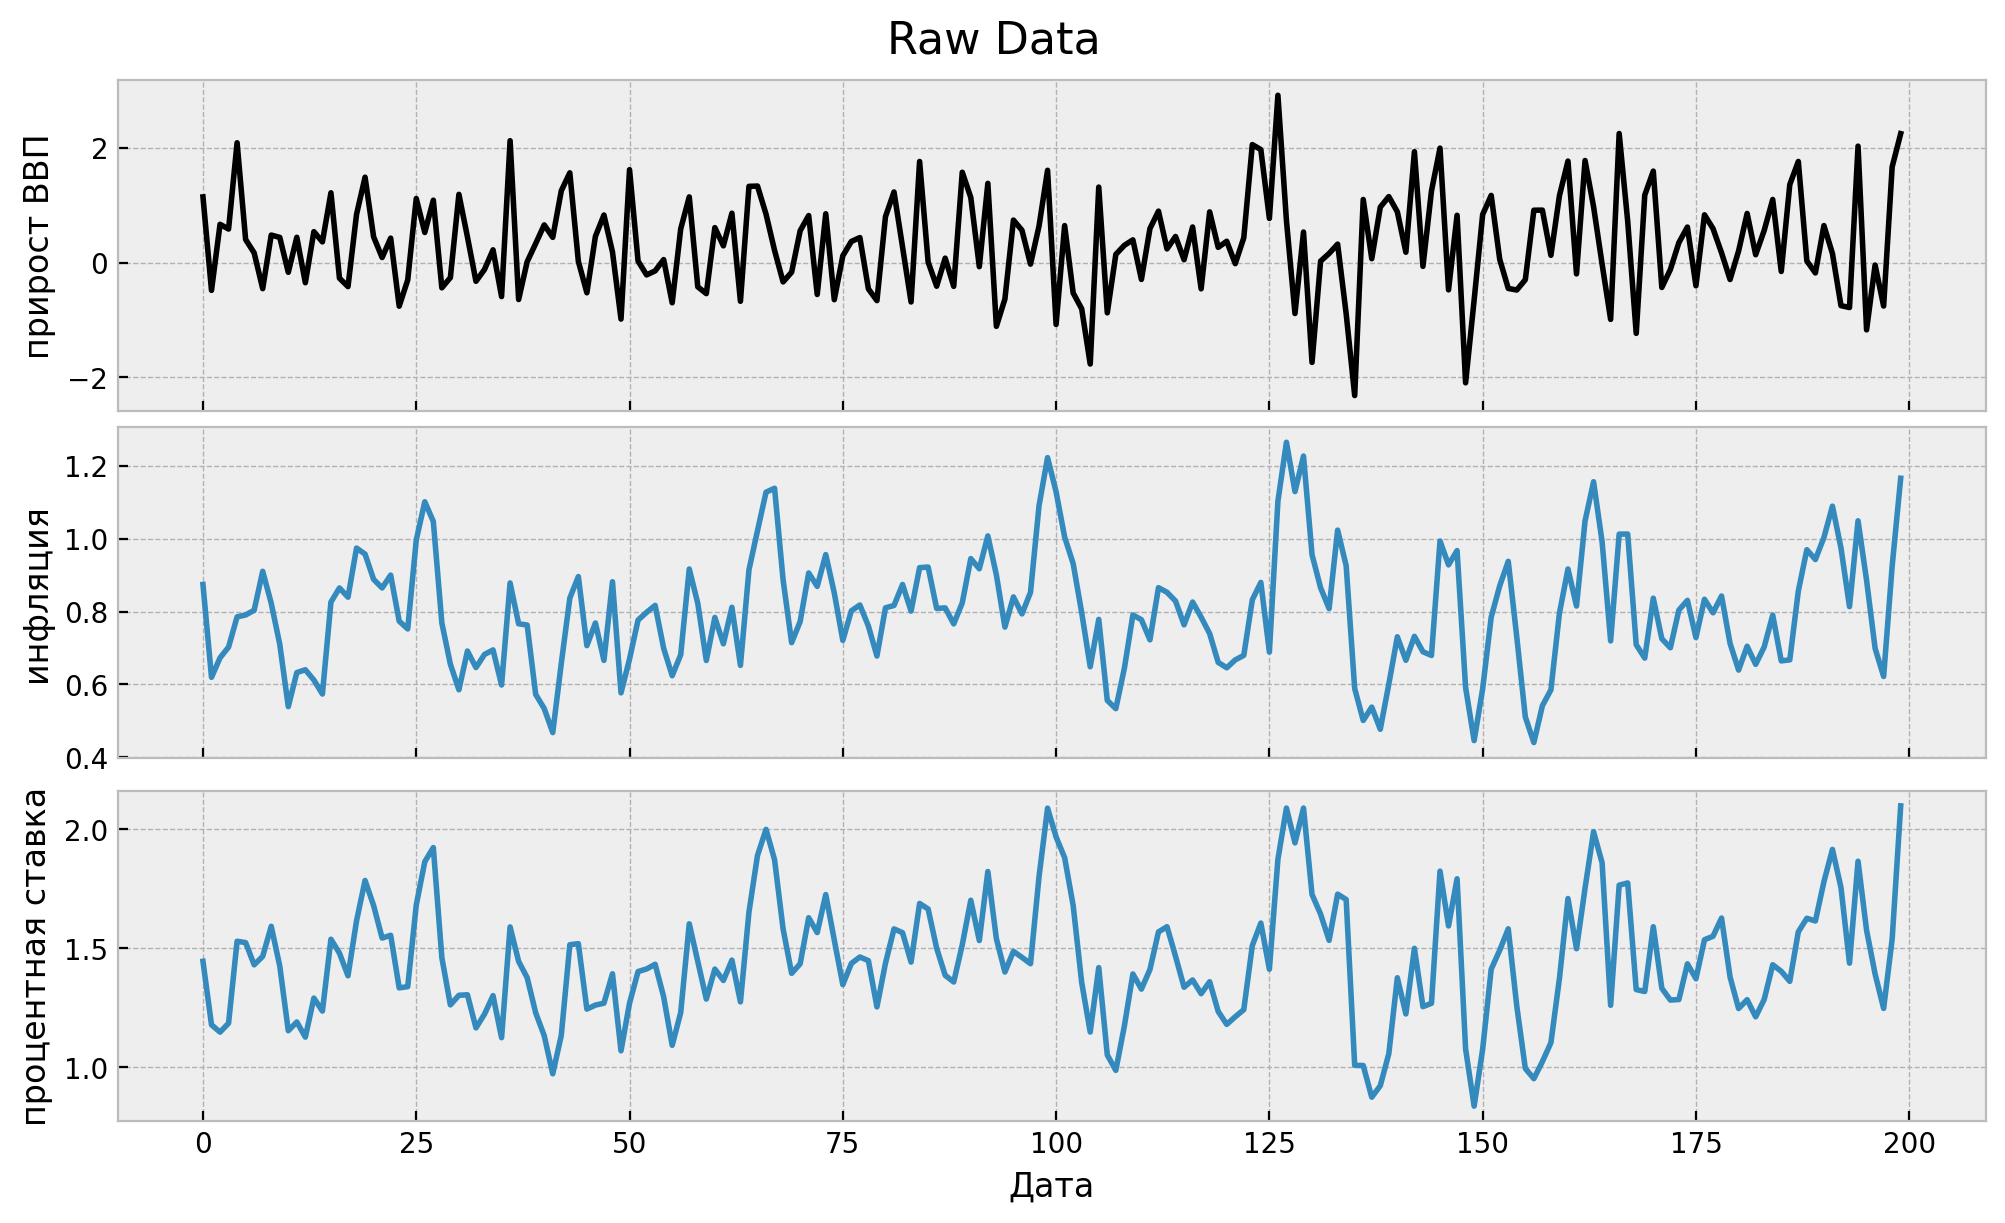

In [14]:
fig, ax = plt.subplots(
    nrows=3, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="Дата", y="прирост ВВП", data=df, color="black", ax=ax[0])
sns.lineplot(x="Дата", y="инфляция", data=df, color="C0", ax=ax[1])
sns.lineplot(x="Дата", y="процентная ставка", data=df, color="C0", ax=ax[2])
fig.suptitle("Raw Data", fontsize=16)
plt.show()

In [5]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

ModuleNotFoundError: No module named 'torch'

In [15]:
start_date = 0
train_test_date = df.shape[0]

print(f"Training Set Length: {(train_test_date - start_date)} days")

Training Set Length: 200 days


In [42]:
treatment_time = 150

In [43]:
# Split into pre and post intervention dataframes
df_train = df[df.index < treatment_time]
df_test = df[df.index >= treatment_time]
n_train = df_train.shape[0]
n_test = df_test.shape[0]
n = n_test + n_train

[Text(0.5, 1.0, 'прирост ВВП - Train/Test Split')]

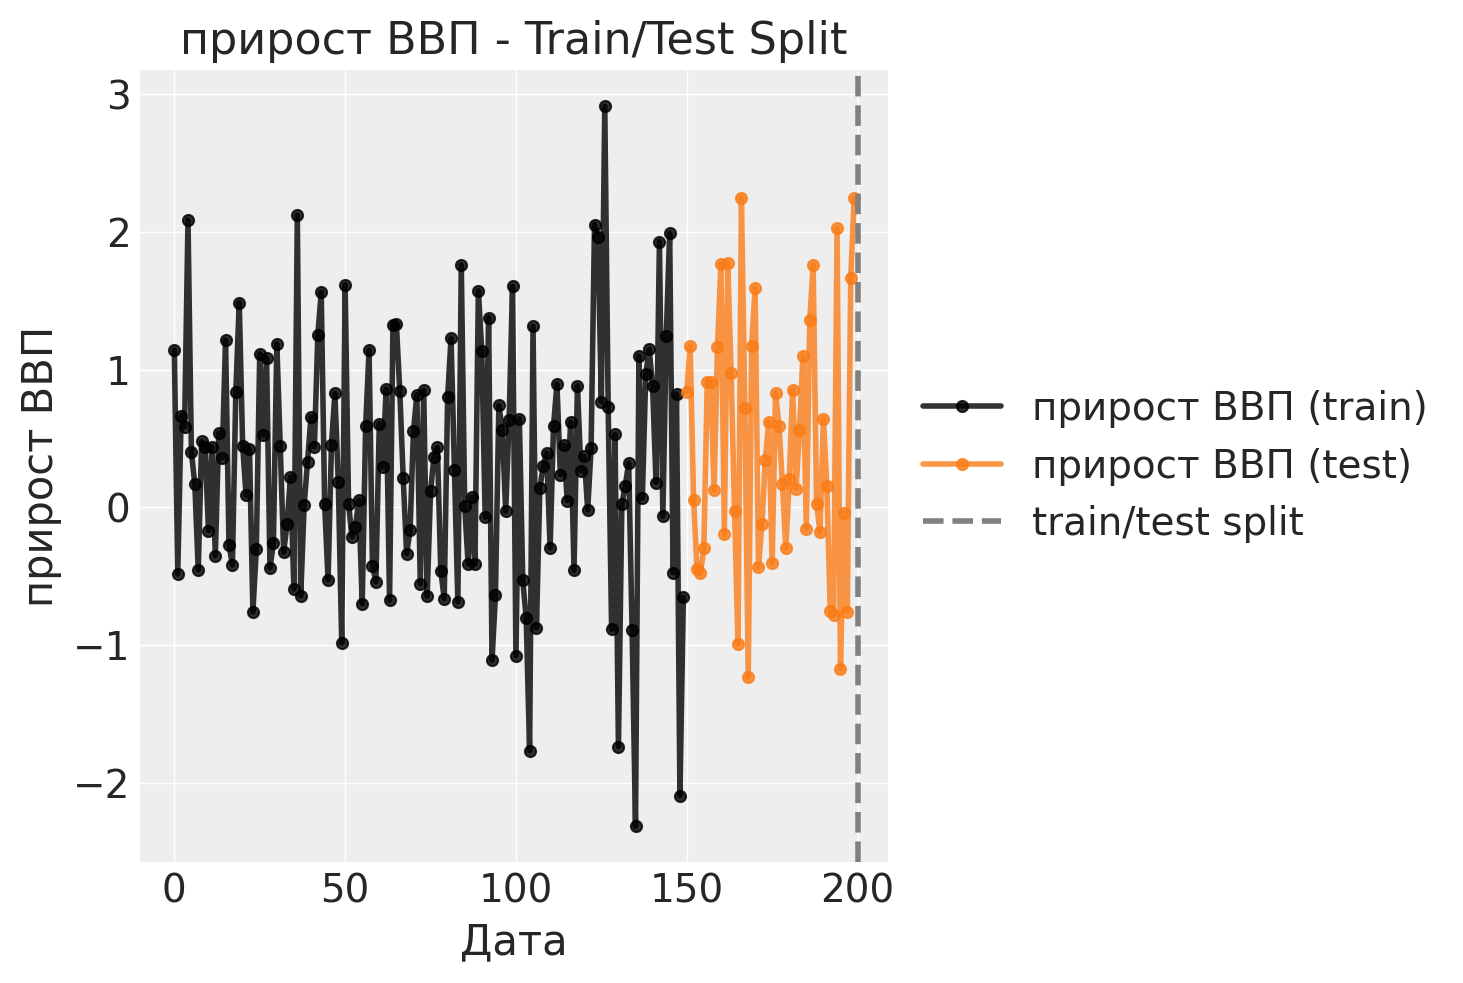

In [44]:
fig, ax = plt.subplots()
sns.lineplot(
    x="Дата",
    y="прирост ВВП",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="прирост ВВП (train)",
    ax=ax,
)
sns.lineplot(
    x="Дата",
    y="прирост ВВП",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="прирост ВВП (test)",
    ax=ax,
)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="прирост ВВП - Train/Test Split")

In [ ]:
# We extract useful features.
date = df["date"]
temp_scaled = df["temp_scaled"]
trend = df["trend"]
sales = df["прирост ВВП"]
# We extract the day of week for the sales model below.
dayofweek_idx, dayofweek = df["date"].dt.dayofweek.factorize()

In [17]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from scipy.stats import norm

In [18]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [19]:
def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

In [20]:
treatment_time = 150

In [21]:
# Split into pre and post intervention dataframes
pre = df[df.index < treatment_time]
post = df[df.index >= treatment_time]

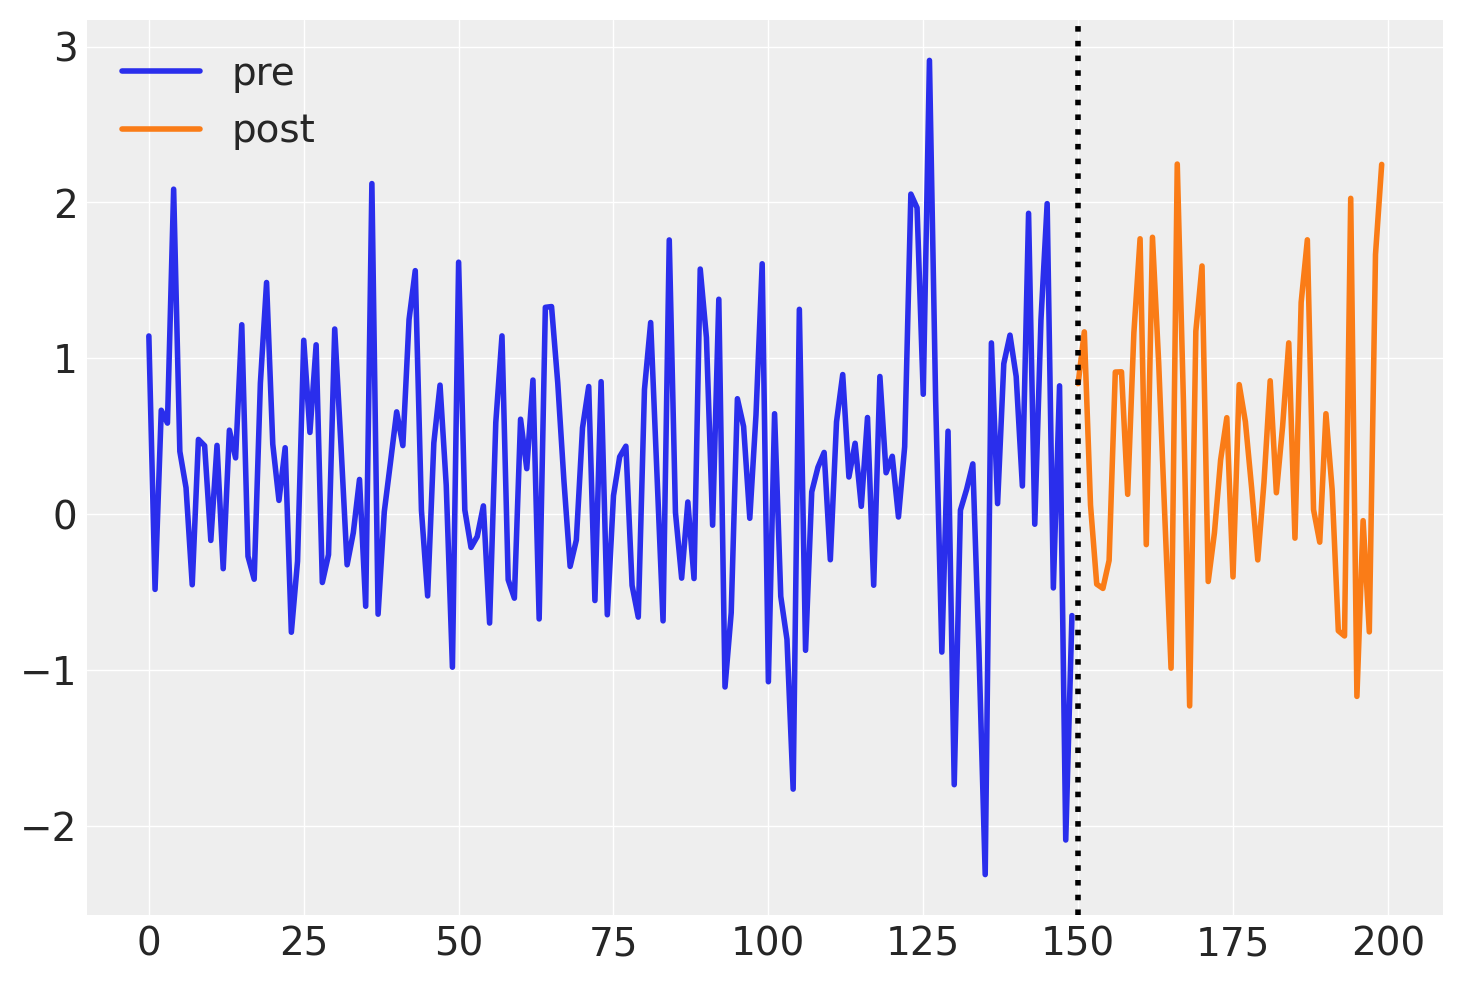

In [22]:
fig, ax = plt.subplots()
ax = pre["прирост ВВП"].plot(label="pre")
post["прирост ВВП"].plot(ax=ax, label="post")
ax.axvline(treatment_time, c="k", ls=":")
plt.legend();


In [23]:
with pm.Model() as model:
    # observed predictors and outcome
    time = pm.MutableData("Дата", pre["Дата"].to_numpy(), dims="obs_id")
    # priors
    beta0 = pm.Normal("beta0", 0, 1)
    beta1 = pm.Normal("beta1", 0, 0.2)
    # the actual linear model
    mu = pm.Deterministic("mu", beta0 + (beta1 * time), dims="obs_id")
    sigma = pm.HalfNormal("sigma", 2)
    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=pre["прирост ВВП"].to_numpy(), dims="obs_id")

In [27]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

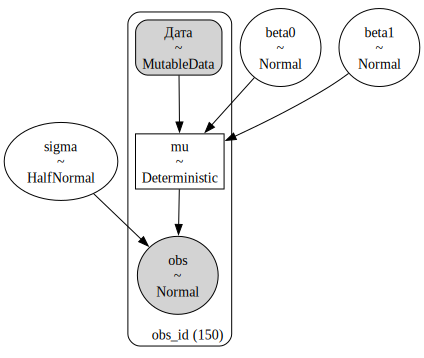

In [28]:
pm.model_to_graphviz(model)

Sampling: [beta0, beta1, obs, sigma]


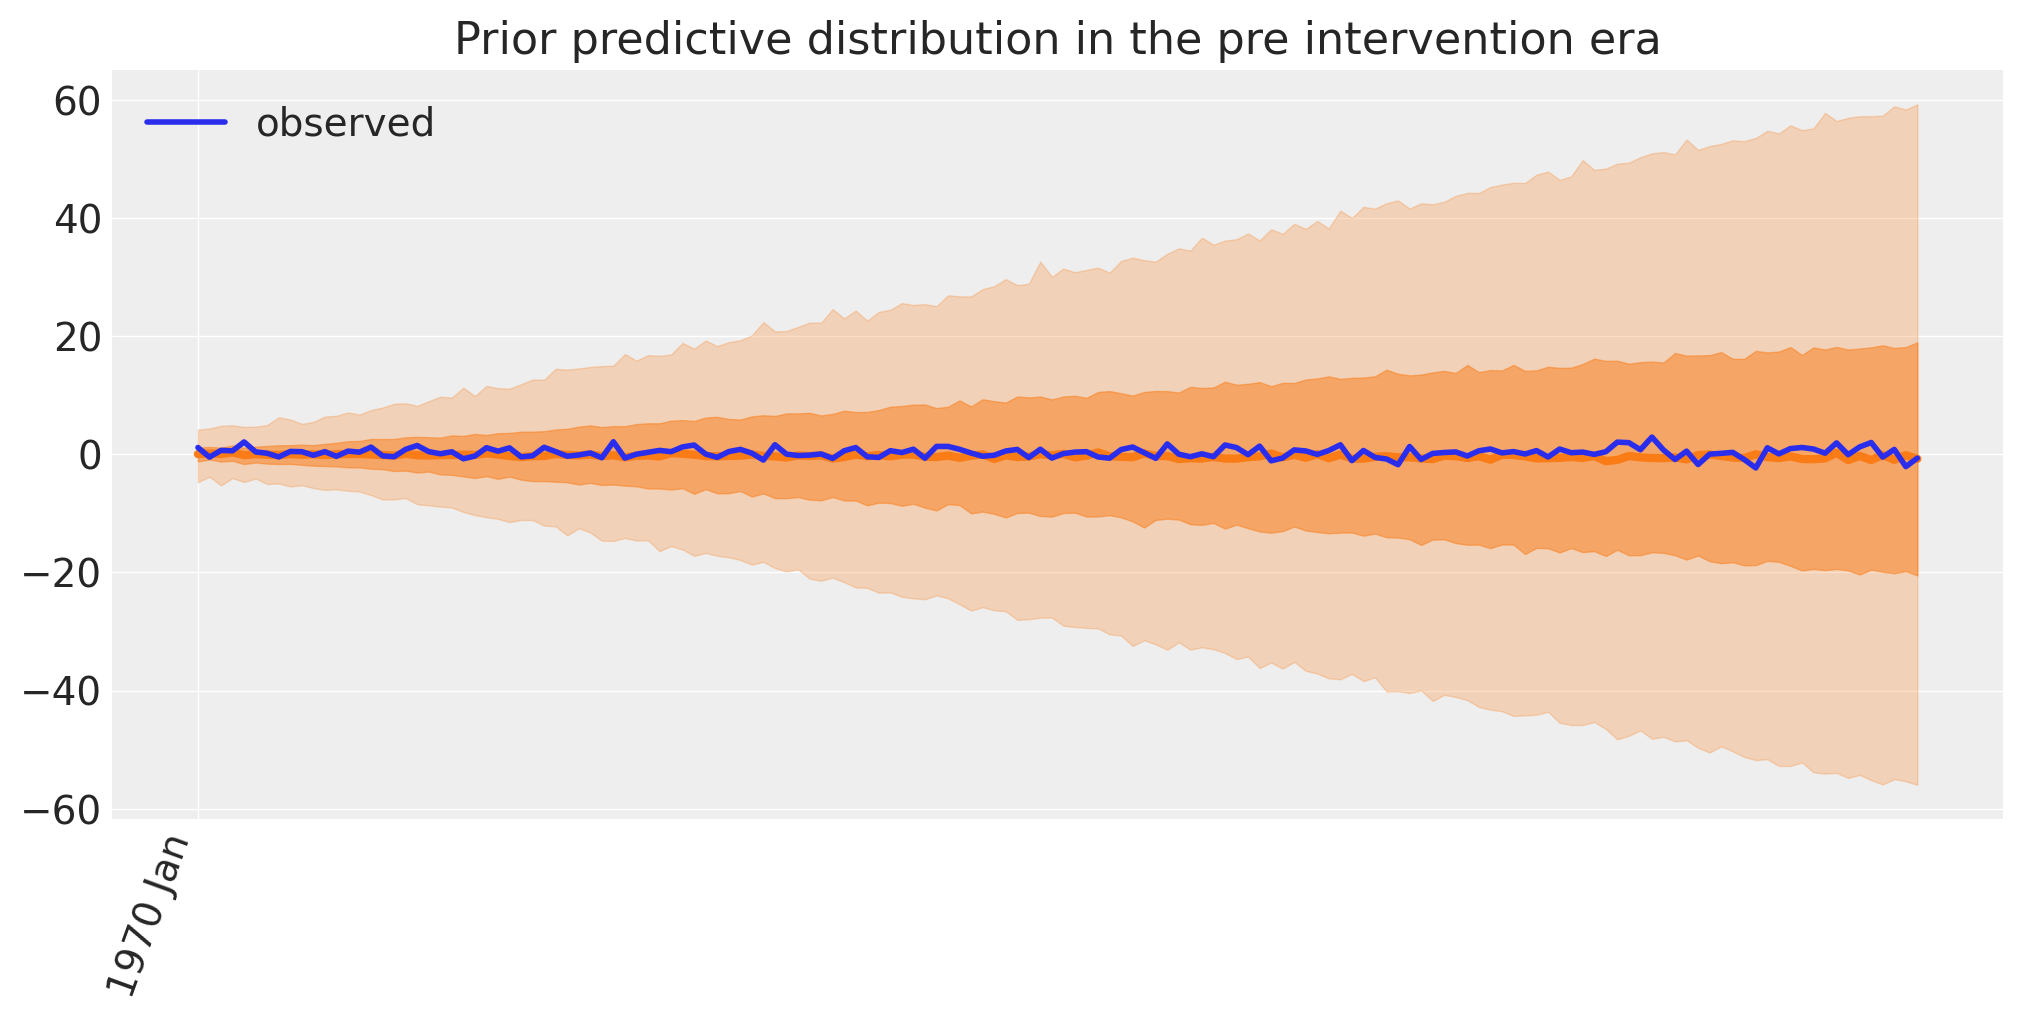

In [29]:
with model:
    idata = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre.index, idata.prior_predictive["obs"], ax)
format_x_axis(ax)
ax.plot(pre.index, pre["прирост ВВП"], label="observed")
ax.set(title="Prior predictive distribution in the pre intervention era")
plt.legend();

In [30]:
with model:
    idata.extend(pm.sample(random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 287 seconds.


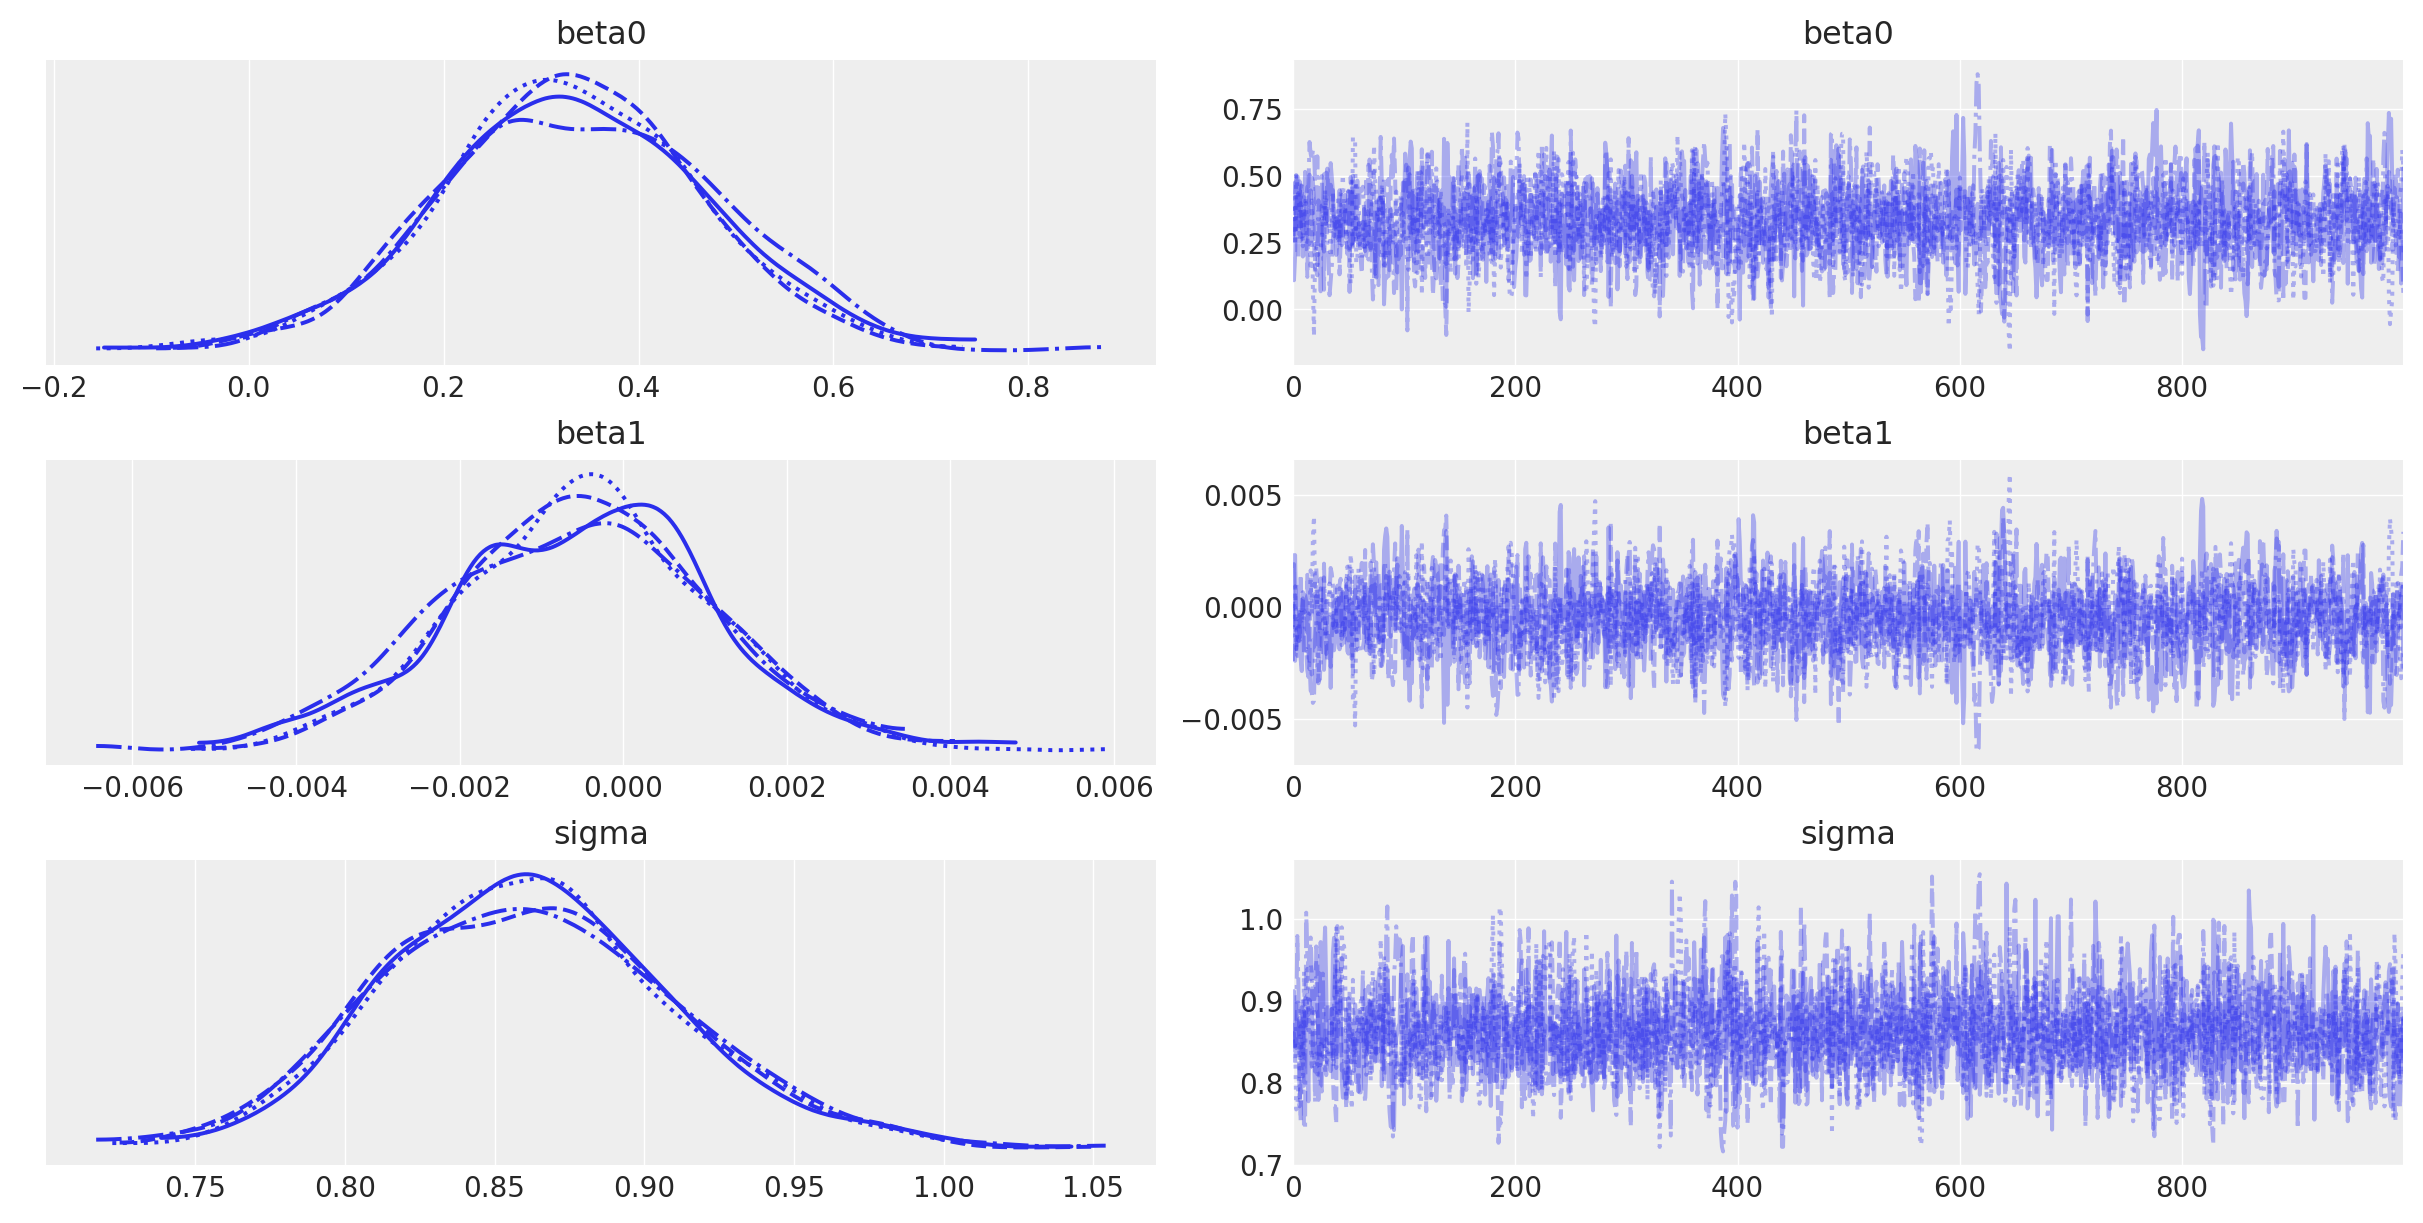

In [31]:
az.plot_trace(idata, var_names=["~mu"]);

Sampling: [obs]


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

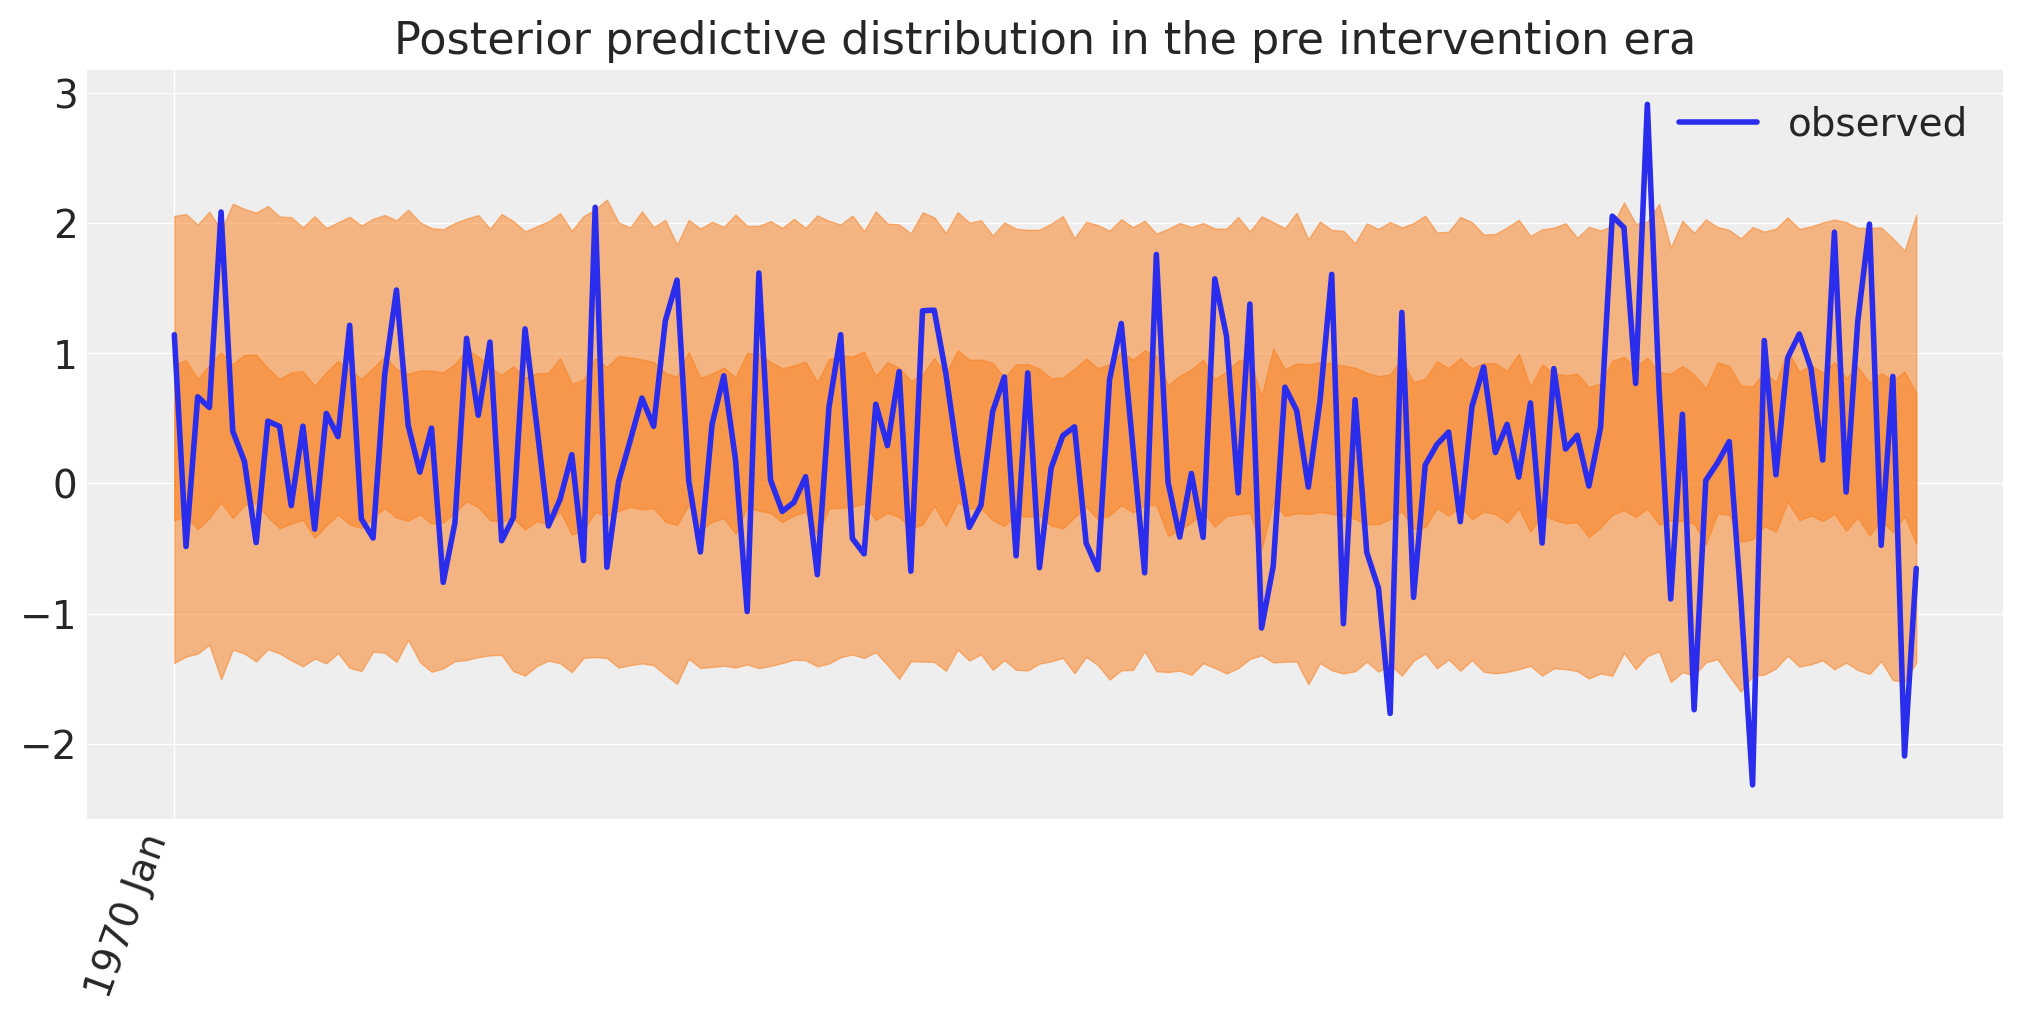

In [32]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))

fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(pre.index, pre["прирост ВВП"], label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre intervention era")
plt.legend();

In [33]:
# convert outcome into an XArray object with a labelled dimension to help in the next step
y = xr.DataArray(pre["прирост ВВП"].to_numpy(), dims=["obs_id"])

# do the calculation by taking the difference
excess = y - idata.posterior_predictive["obs"]

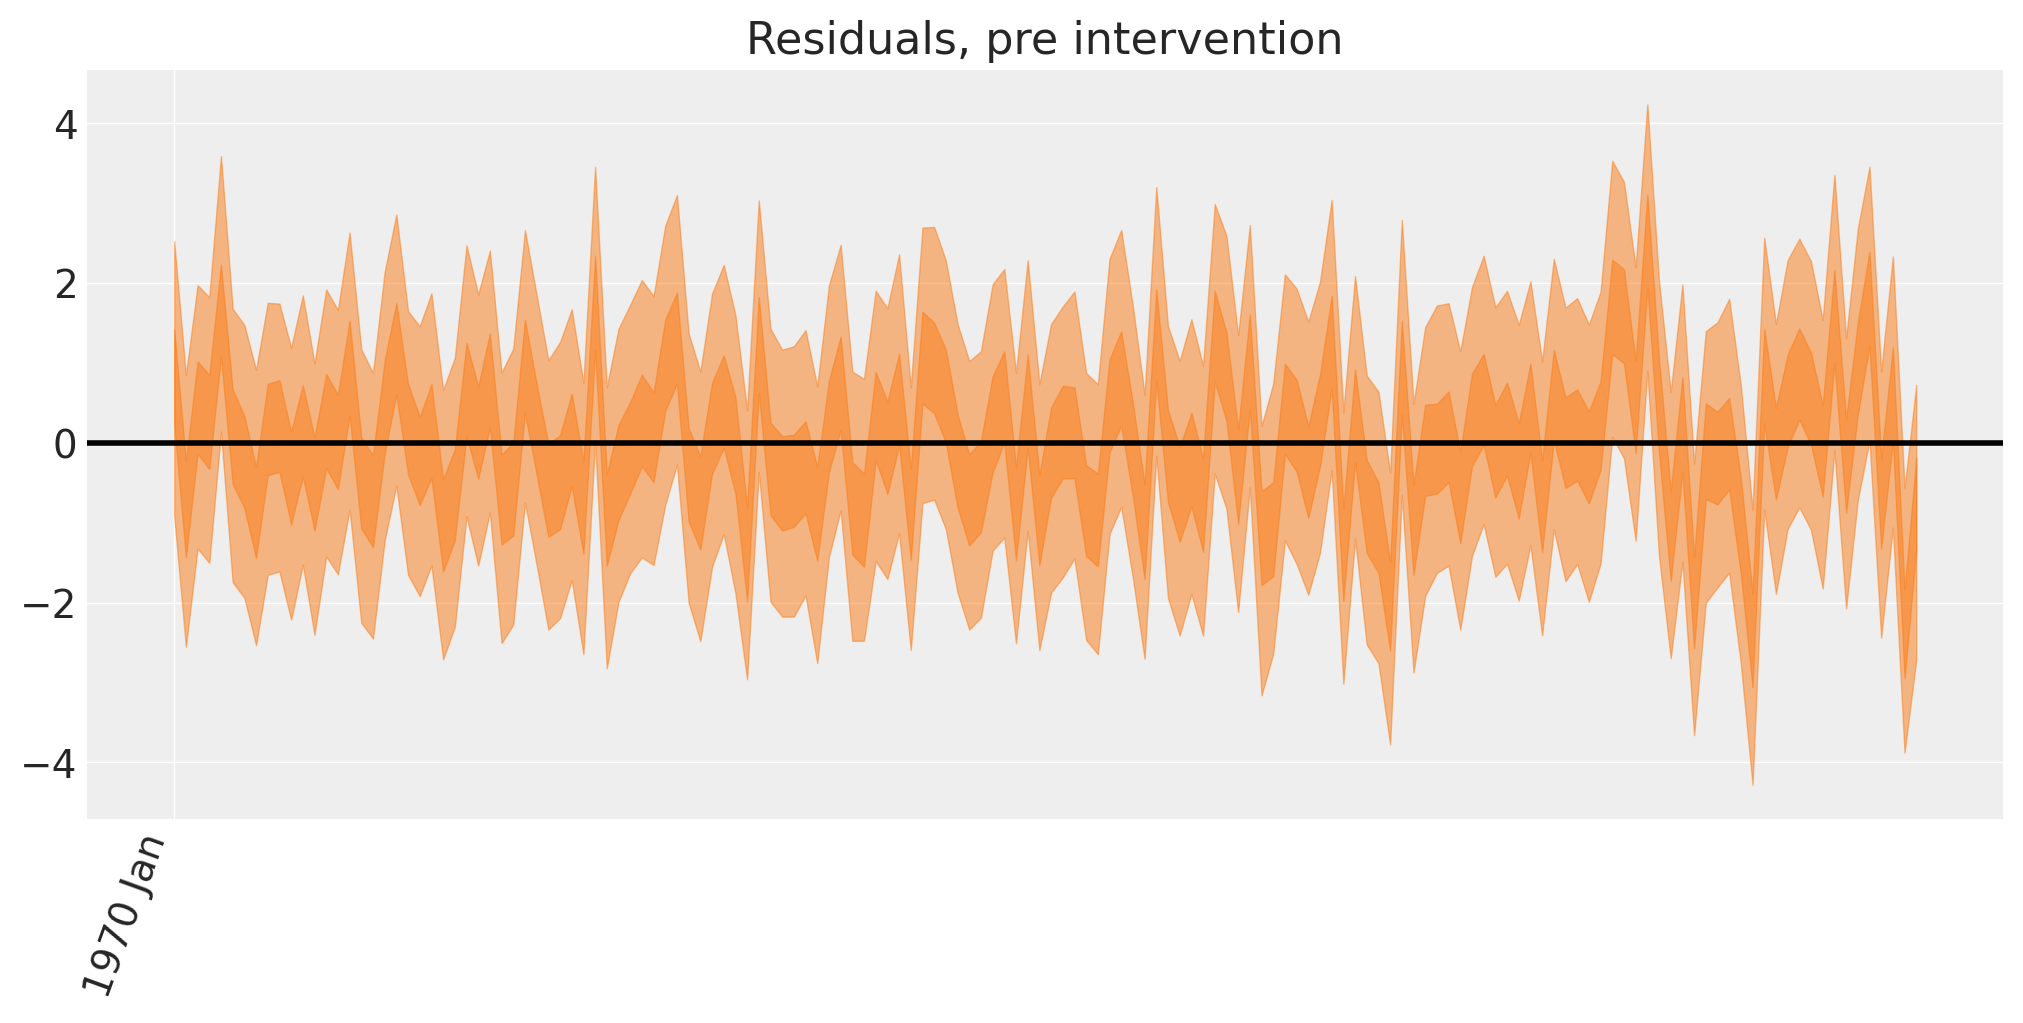

In [34]:
fig, ax = plt.subplots(figsize=figsize)
# the transpose is to keep arviz happy, ordering the dimensions as (chain, draw, time)
az.plot_hdi(pre.index, excess.transpose(..., "obs_id"), hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, excess.transpose(..., "obs_id"), hdi_prob=0.95, smooth=False)
format_x_axis(ax)
ax.axhline(y=0, color="k")
ax.set(title="Residuals, pre intervention");

In [36]:
with model:
    pm.set_data(
        {
            "Дата": post["Дата"].to_numpy(),
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=RANDOM_SEED
    )

Sampling: [obs]


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

In [38]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(post.index, counterfactual.posterior_predictive["obs"], ax)
format_x_axis(ax, minor=False)
ax.plot(post.index, post["прирост ВВП"], label="observed")
ax.set(
    title="Counterfactual: Posterior predictive forecast of outcome if intervention not taken place"
)
plt.legend();

In [39]:
# convert outcome into an XArray object with a labelled dimension to help in the next step
outcome = xr.DataArray(post["прирост ВВП"].to_numpy(), dims=["obs_id"])

# do the calculation by taking the difference
excess = outcome - counterfactual.posterior_predictive["obs"]

In [40]:
# calculate the cumulative causal impact
cumsum = excess.cumsum(dim="obs_id")

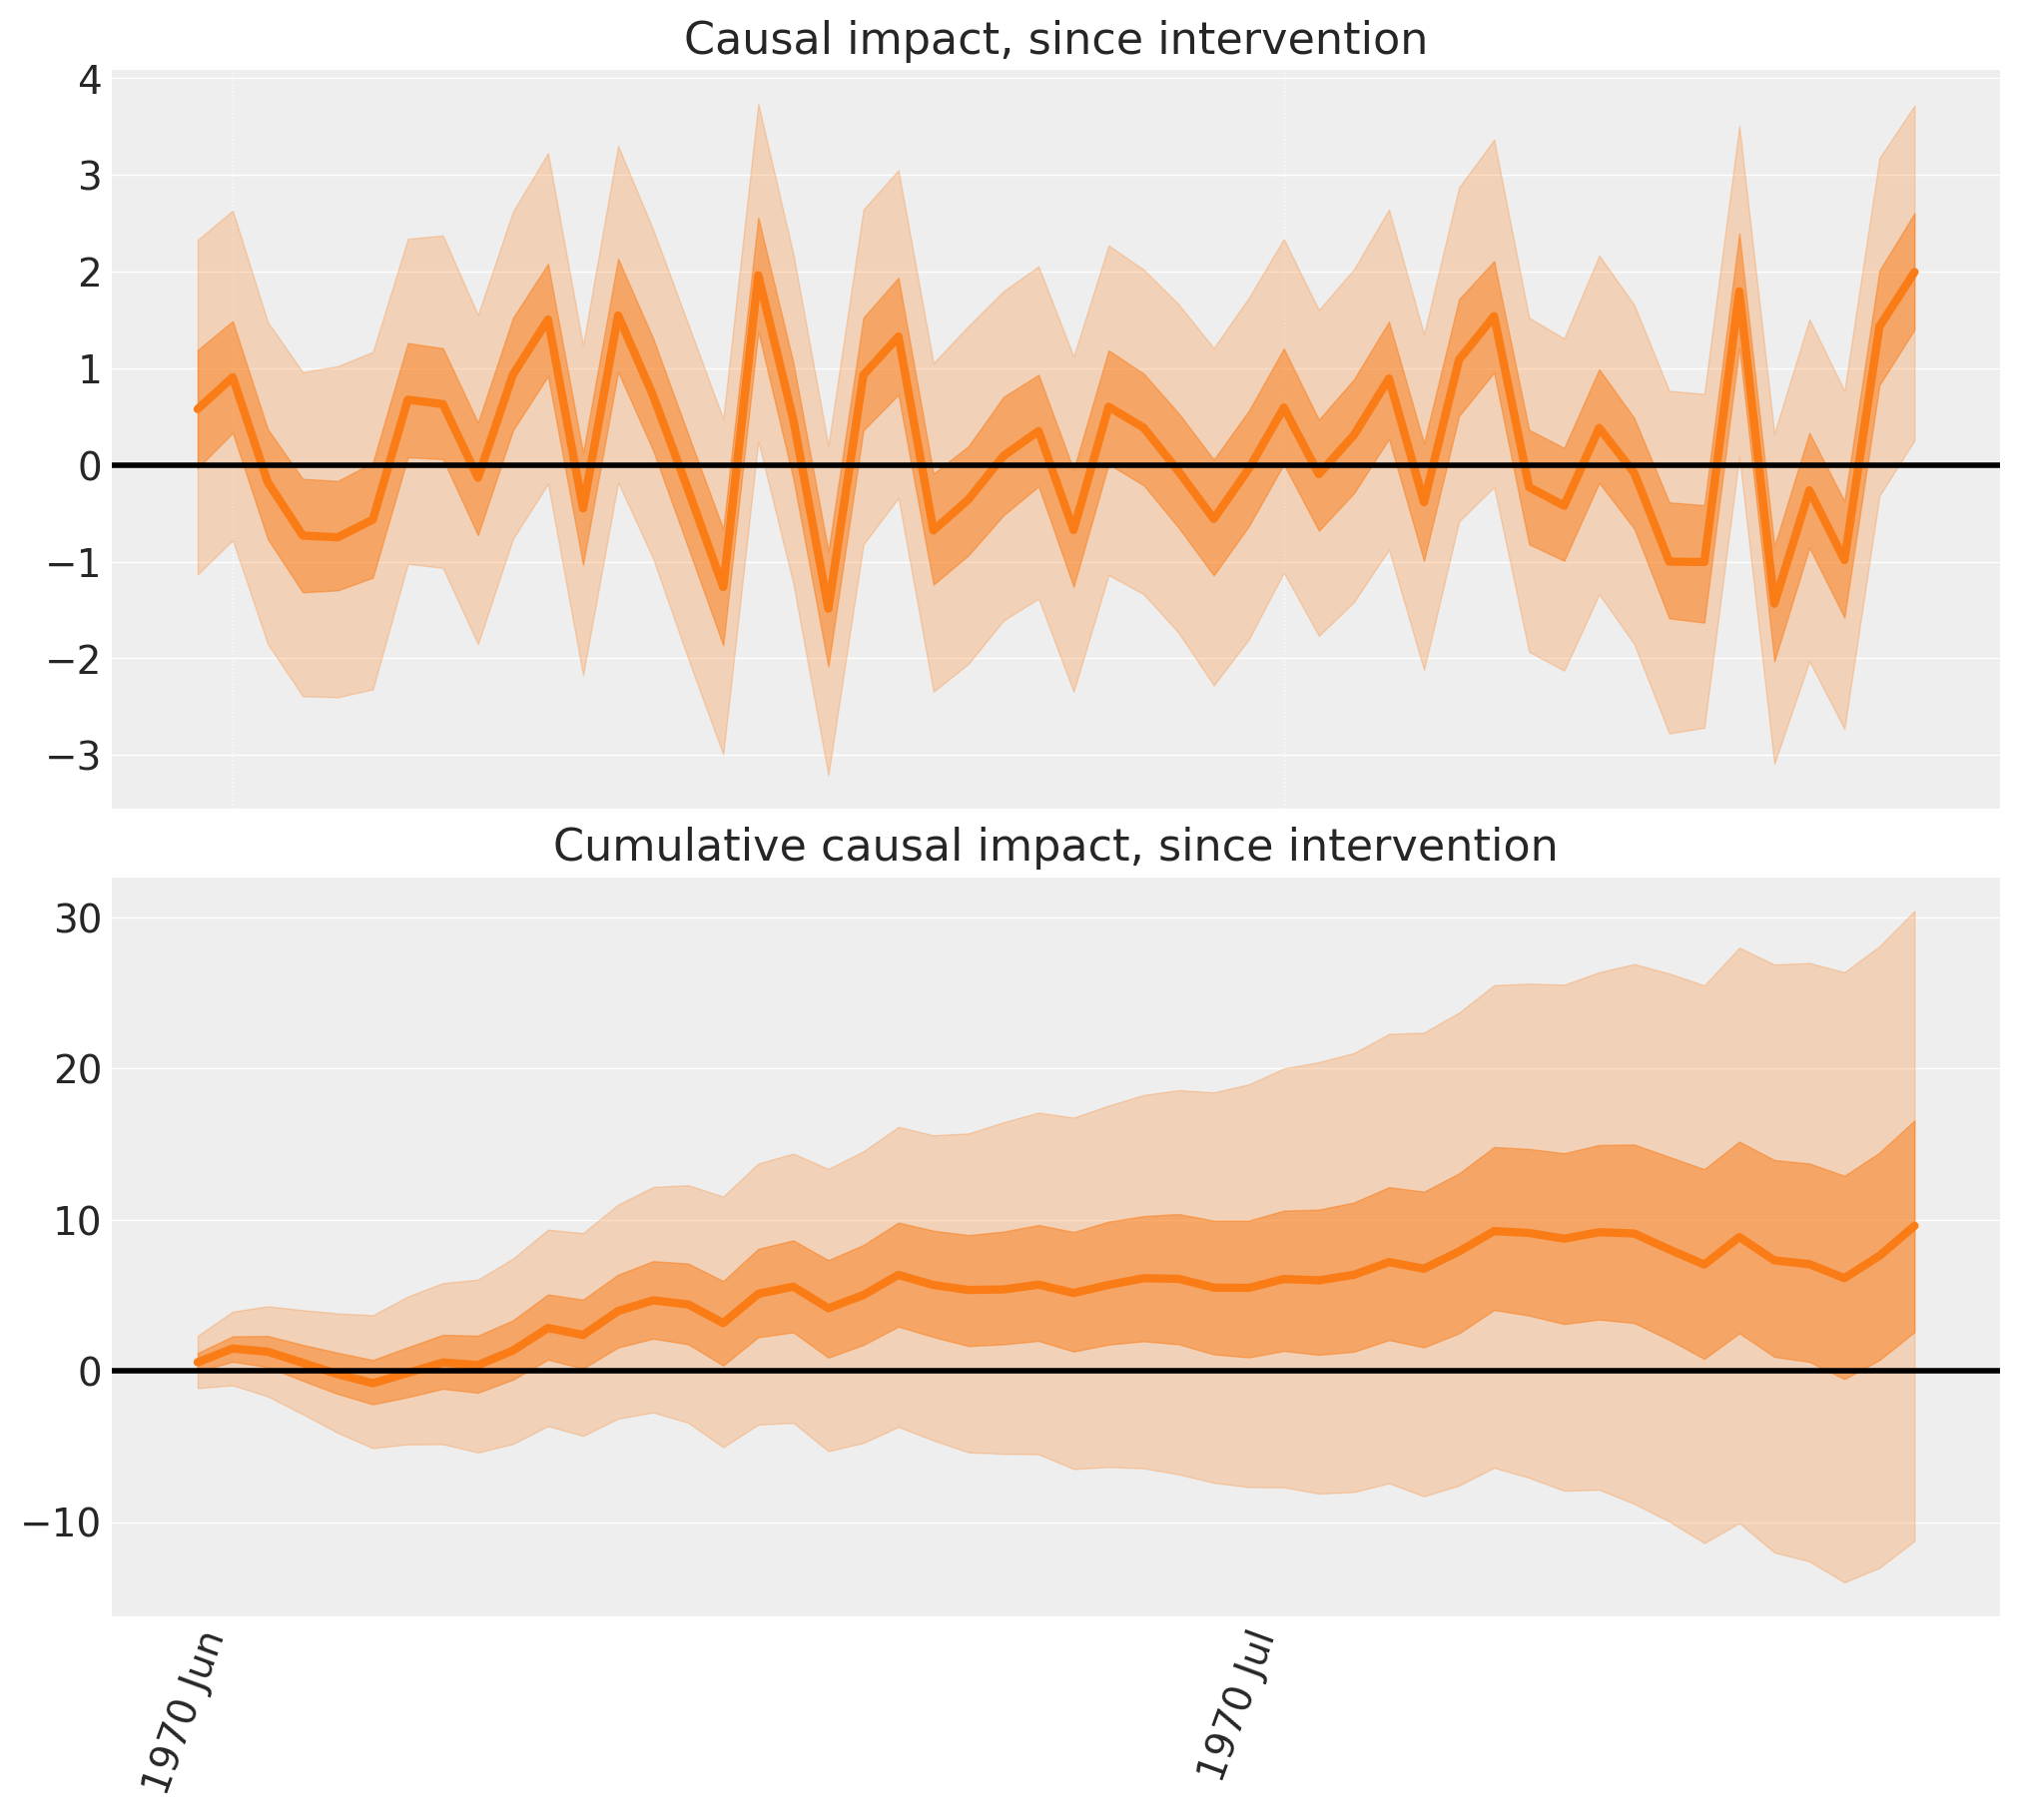

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(post.index, excess.transpose(..., "obs_id"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Causal impact, since intervention")

# Plot the cumulative excess
plot_xY(post.index, cumsum.transpose(..., "obs_id"), ax[1])
format_x_axis(ax[1], minor=False)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative causal impact, since intervention");

In [16]:
# 3-мерный тестовый массив размера 100 000 х 200 х 3 с симуляциями данных по приросту ВВП, инфляции и процентной ставки
# Для этих данных необходимо построить прогноз параметров
y_smp_test = np.load("data/test/y_smp_test.npy")
y_smp_test[:3]


array([[[ 6.18020489, -1.60246727,  0.53633144],
        [-3.31159309,  1.34235087,  1.27781956],
        [ 1.13971284,  0.44974921,  1.22196404],
        ...,
        [ 0.65911036,  1.06125659,  1.10764883],
        [ 3.98138166, -0.30064017,  0.78664017],
        [-2.90192765,  1.51276899,  1.32060105]],

       [[ 0.78226124,  1.07162835,  1.29879078],
        [ 0.77731289,  0.6049763 ,  1.0738958 ],
        [-0.94206088,  0.70082783,  0.95289799],
        ...,
        [ 0.60972697,  0.31193782,  1.26403514],
        [ 0.01794818,  1.15206346,  1.53664382],
        [ 1.20711718,  0.44762037,  1.17774849]],

       [[ 0.42630142,  1.21500071,  2.5640936 ],
        [ 0.31149241,  0.81182898,  2.04631416],
        [-0.19228794, -0.09839751,  0.79582221],
        ...,
        [ 1.37422871,  1.92649191,  3.09302096],
        [ 0.29980895,  1.40371681,  2.77236719],
        [ 2.16341687,  2.7531414 ,  4.22434937]]])